#Импортируем библиотеки

In [1]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [8]:
import joblib
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score

#Предобработка данных
Превращаем логи в списки

Загружаем тариффы

In [9]:
tarrif_all_user = pd.read_csv('01_all_users.csv')

Достаем из логов события, а также даты взяв из них функции (min, max и тд)

In [10]:
ev_log = pd.read_csv('02_events_log.csv').drop('event_date', axis=1)
ev_log = ev_log.groupby(['contract_id']).agg(lambda x: '|'.join(x)).reset_index()
ev_log['event_type'] = ev_log['event_type'].str.replace('\|+', '|')
ev_log['event_type'] = ev_log['event_type'].str.replace('\s*\|\s*', '|')
ev_log['event_type'] = ev_log['event_type'].str.split('|')
people_without_log = list(set(tarrif_all_user.contract_id) ^ set(ev_log.contract_id))
ev_log = ev_log.append(pd.DataFrame(data={'contract_id':people_without_log, 'event_type':[['0'] for x in range(len(people_without_log))]}))
ev_log = ev_log.rename({'event_type':'event_log'}, axis=1)
ev_log['event_log_word'] = ev_log.event_log.apply(lambda x: ' '.join(x))

ev_log_date = pd.read_csv('02_events_log.csv').drop('event_type', axis=1)
ev_log_date['event_date'] = pd.to_datetime(ev_log_date['event_date'])
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: min(x.dt.month)).reset_index().rename({'event_date':'month_min'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: max(x.dt.month)).reset_index().rename({'event_date':'month_max'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.month.mean()).reset_index().rename({'event_date':'month_mean'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.month.median()).reset_index().rename({'event_date':'month_median'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: min(x.dt.month.mode())).reset_index().rename({'event_date':'month_min_mode'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: max(x.dt.month.mode())).reset_index().rename({'event_date':'month_max_mode'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: min(x.dt.day)).reset_index().rename({'event_date':'day_min'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: max(x.dt.day)).reset_index().rename({'event_date':'day_max'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.day.mean()).reset_index().rename({'event_date':'day_mean'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.day.median()).reset_index().rename({'event_date':'day_median'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: min(x.dt.day.mode())).reset_index().rename({'event_date':'day_min_mode'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: max(x.dt.day.mode())).reset_index().rename({'event_date':'day_max_mode'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: min(x.dt.hour)).reset_index().rename({'event_date':'hour_min'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: max(x.dt.hour)).reset_index().rename({'event_date':'hour_max'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.hour.mean()).reset_index().rename({'event_date':'hour_mean'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: min(x.dt.hour.mode())).reset_index().rename({'event_date':'hour_min_mode'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: max(x.dt.hour.mode())).reset_index().rename({'event_date':'hour_max_mode'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: np.sin(x.dt.hour * 2 * np.pi / 24).mean()).reset_index().rename({'event_date':'hour_sin_mean'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: np.cos(x.dt.hour * 2 * np.pi / 24).mean()).reset_index().rename({'event_date':'hour_cos_mean'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.hour.median()).reset_index().rename({'event_date':'hour_median'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: min(x.dt.weekday)).reset_index().rename({'event_date':'weekday_min'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: max(x.dt.weekday)).reset_index().rename({'event_date':'weekday_max'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.weekday.mean()).reset_index().rename({'event_date':'weekday_mean'}, axis=1), on='contract_id')
ev_log = pd.merge(ev_log, ev_log_date.groupby(['contract_id']).agg(lambda x: x.dt.weekday.median()).reset_index().rename({'event_date':'weekday_median'}, axis=1), on='contract_id')

In [11]:
lk_log = pd.read_csv('03_lk_events_log.csv').drop('event_date', axis=1)
lk_log = lk_log.groupby(['contract_id']).agg(lambda x: '|'.join(x)).reset_index()
lk_log['name'] = lk_log['name'].str.replace('\|+', '|')
lk_log['name'] = lk_log['name'].str.replace('\s*\|\s*', '|')
lk_log['name'] = lk_log['name'].str.split('|')
people_without_log = list(set(tarrif_all_user.contract_id) ^ set(lk_log.contract_id))
lk_log = lk_log.append(pd.DataFrame(data={'contract_id':people_without_log, 'name':[['0'] for x in range(len(people_without_log))]}))
lk_log = lk_log.rename({'name':'lk_event_log'}, axis=1)
lk_log['lk_event_log_word'] = lk_log.lk_event_log.apply(lambda x: ' '.join(x))

lk_log_data = pd.read_csv('02_events_log.csv').drop('event_type', axis=1)
lk_log_data['event_date'] = pd.to_datetime(lk_log_data['event_date'])
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: max(x.dt.month)).reset_index().rename({'event_date':'lk_month_max'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.month.mean()).reset_index().rename({'event_date':'lk_month_mean'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.month.median()).reset_index().rename({'event_date':'lk_month_median'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: min(x.dt.month.mode())).reset_index().rename({'event_date':'lk_month_min_mode'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: max(x.dt.month.mode())).reset_index().rename({'event_date':'lk_month_max_mode'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: min(x.dt.day)).reset_index().rename({'event_date':'lk_day_min'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: max(x.dt.day)).reset_index().rename({'event_date':'lk_day_max'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.day.mean()).reset_index().rename({'event_date':'lk_day_mean'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.day.median()).reset_index().rename({'event_date':'lk_day_median'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: min(x.dt.day.mode())).reset_index().rename({'event_date':'lk_day_min_mode'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: max(x.dt.day.mode())).reset_index().rename({'event_date':'lk_day_max_mode'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: min(x.dt.hour)).reset_index().rename({'event_date':'lk_hour_min'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: max(x.dt.hour)).reset_index().rename({'event_date':'lk_hour_max'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.hour.mean()).reset_index().rename({'event_date':'lk_hour_mean'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: np.sin(x.dt.hour * 2 * np.pi / 24).mean()).reset_index().rename({'event_date':'lk_hour_sin_mean'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: np.cos(x.dt.hour * 2 * np.pi / 24).mean()).reset_index().rename({'event_date':'lk_hour_cos_mean'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.hour.median()).reset_index().rename({'event_date':'lk_hour_median'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: min(x.dt.hour.mode())).reset_index().rename({'event_date':'lk_hour_min_mode'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: max(x.dt.hour.mode())).reset_index().rename({'event_date':'lk_hour_max_mode'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: min(x.dt.weekday)).reset_index().rename({'event_date':'lk_weekday_min'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: max(x.dt.weekday)).reset_index().rename({'event_date':'lk_weekday_max'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.weekday.mean()).reset_index().rename({'event_date':'lk_weekday_mean'}, axis=1), on='contract_id')
lk_log = pd.merge(lk_log, lk_log_data.groupby(['contract_id']).agg(lambda x: x.dt.weekday.median()).reset_index().rename({'event_date':'lk_weekday_median'}, axis=1), on='contract_id')

Соединяем все вместе и делаем train и test выборку

In [12]:
X_all_people = pd.merge(pd.merge(tarrif_all_user, ev_log, on='contract_id'), lk_log, on='contract_id')

In [13]:
data_train = pd.merge(X_all_people, pd.read_csv('04_is_blocked.csv'), on='contract_id')
X = data_train.drop(['contract_id', 'blocked'], axis=1)
y = data_train['blocked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Модель

In [14]:
def func(x):
  return x

model = Pipeline([('column', ColumnTransformer([('num', StandardScaler(), ['day_or_month_contract','weekday_min','weekday_max','weekday_mean','lk_weekday_min','lk_weekday_max','lk_weekday_mean','month_min', 'month_max', 'month_mean', 'month_median', 'month_max_mode', 'month_min_mode', 'day_min', 'day_max', 'day_mean', 'day_median', 'day_min_mode', 'day_max_mode', 'hour_min', 'hour_max', 'hour_mean', 'hour_min_mode', 'hour_max_mode', 'hour_sin_mean', 'hour_cos_mean', 'hour_median', 'lk_month_max', 'lk_month_mean', 'lk_month_median', 'lk_month_min_mode', 'lk_month_max_mode', 'lk_day_min', 'lk_day_max', 'lk_day_min_mode', 'lk_day_mean', 'lk_day_median', 'lk_day_max_mode', 'lk_hour_min', 'lk_hour_max', 'lk_hour_mean', 'lk_hour_sin_mean', 'lk_hour_cos_mean', 'lk_hour_median', 'lk_hour_min_mode', 'lk_hour_max_mode']),
                            ('evlogs', TfidfVectorizer(analyzer=func), 'event_log'),
                            ('lklogs', TfidfVectorizer(analyzer=func), 'lk_event_log'),
                            ('wordevlogs', TfidfVectorizer(ngram_range=(1,2)), 'event_log_word'),
                            ('wordlklogs', TfidfVectorizer(ngram_range=(1,2)), 'lk_event_log_word')
                  ])),
                  ('model', StackingClassifier([
                            ('xgb', XGBClassifier(learning_rate=0.1, n_estimators=81, subsample=0.8, colsample_bytree=0.8, gamma=5, max_depth=3)),
                            ('cat', CatBoostClassifier(iterations=1000, verbose=100, early_stopping_rounds=50)),
                            ('log', LogisticRegression(penalty='l2', C=0.5, random_state=42))
], cv=2))])
model.fit(X_train, y_train)
print()

Learning rate set to 0.010956
0:	learn: 0.6874919	total: 90.1ms	remaining: 1m 30s
100:	learn: 0.4509129	total: 3.25s	remaining: 28.9s
200:	learn: 0.3933940	total: 6.39s	remaining: 25.4s
300:	learn: 0.3650175	total: 9.5s	remaining: 22.1s
400:	learn: 0.3434764	total: 12.6s	remaining: 18.8s
500:	learn: 0.3258111	total: 15.8s	remaining: 15.7s
600:	learn: 0.3097979	total: 18.9s	remaining: 12.6s
700:	learn: 0.2944381	total: 22.1s	remaining: 9.43s
800:	learn: 0.2818676	total: 25.2s	remaining: 6.27s
900:	learn: 0.2674890	total: 28.3s	remaining: 3.11s
999:	learn: 0.2517425	total: 31.4s	remaining: 0us


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Learning rate set to 0.008146
0:	learn: 0.6889925	total: 23.5ms	remaining: 23.5s
100:	learn: 0.4666964	total: 1.95s	remaining: 17.3s
200:	learn: 0.3958729	total: 3.87s	remaining: 15.4s
300:	learn: 0.3574065	total: 5.8s	remaining: 13.5s
400:	learn: 0.3304527	total: 7.73s	remaining: 11.6s
500:	learn: 0.3100349	total: 9.66s	remaining: 9.62s
600:	learn: 0.2928461	total: 11.6s	remaining: 7.69s
700:	learn: 0.2769637	total: 13.5s	remaining: 5.76s
800:	learn: 0.2625185	total: 15.4s	remaining: 3.84s
900:	learn: 0.2508659	total: 17.4s	remaining: 1.91s
999:	learn: 0.2386786	total: 19.3s	remaining: 0us
Learning rate set to 0.008152
0:	learn: 0.6889734	total: 25.3ms	remaining: 25.3s
100:	learn: 0.4770224	total: 2.07s	remaining: 18.4s
200:	learn: 0.4065082	total: 4.15s	remaining: 16.5s
300:	learn: 0.3670111	total: 6.22s	remaining: 14.5s
400:	learn: 0.3380567	total: 8.3s	remaining: 12.4s
500:	learn: 0.3153301	total: 10.4s	remaining: 10.3s
600:	learn: 0.2942218	total: 12.5s	remaining: 8.27s
700:	learn

График roc auc

ROC AUC: 0.76223


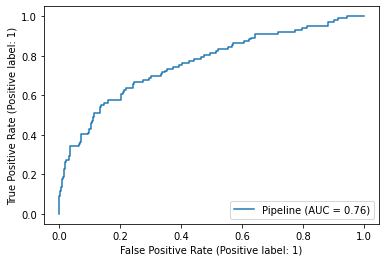

In [15]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_test, y_test)
print('ROC AUC: {:.5f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

#Итог

Делаем test предсказания

In [16]:
data_test = pd.merge(X_all_people, pd.read_csv('test.csv'), on='contract_id')
data_test.blocked = model.predict(data_test.drop(['contract_id', 'blocked'], axis=1))
data_test[['contract_id', 'blocked']].to_csv('our_test.csv', index=False)

Сохраняем модель

In [18]:
joblib.dump(model, 'model.joblib', compress=9)

['model.joblib']

Можно также его потом загрузить

In [21]:
model = joblib.load('model.joblib') 